In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import combinations

from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F

In [2]:
def read_envi_bin(hdr_file, bin_file):
    # Parse .hdr file
    metadata = {}
    with open(hdr_file, 'r') as f:
        for line in f:
            if '=' in line:
                key, value = line.strip().split('=')
                metadata[key.strip()] = value.strip()
    
    # Extract metadata
    samples = int(metadata['samples'])
    lines = int(metadata['lines'])
    bands = int(metadata['bands'])
    data_type_map = {
        '1': np.uint8,
        '2': np.int16,
        '3': np.int32,
        '4': np.float32
    }
    dtype = data_type_map[metadata['data type']]
    interleave = metadata['interleave']
    byte_order = '>' if metadata['byte order'] == '1' else '<'  # Big or little endian
    
    # Read binary file
    data = np.fromfile(bin_file, dtype=byte_order + dtype().dtype.char)
    
    # Reshape based on interleave format
    if interleave == 'bip':
        data = data.reshape((lines, samples, bands))
    elif interleave == 'bil':
        data = data.reshape((lines, bands, samples))
    elif interleave == 'bsq':
        data = data.reshape((bands, lines, samples))
    else:
        raise ValueError("Unsupported interleave format: " + interleave)
    
    return data

def load_mango_data(base_dir):
    mango_data = {}
    # Iterate over all day folders
    for day in range(1, 13):
        day_folder = os.path.join(base_dir, f"day_{day}_m3")
        if not os.path.exists(day_folder):
            continue
        
        # Iterate over all mango files in the folder
        for mango_id in range(1, 41):
            mango_id_str = f"{mango_id:02d}"  # Ensure two-digit format
            hdr_file = os.path.join(day_folder, f"mango_day_{day}_m3_{mango_id_str}_front.hdr")
            bin_file = os.path.join(day_folder, f"mango_day_{day}_m3_{mango_id_str}_front.bin")
            
            if os.path.exists(hdr_file) and os.path.exists(bin_file):
                try:
                    data = read_envi_bin(hdr_file, bin_file)
                    # Store data in the dictionary with (day, mango_id) as key
                    mango_data[(day, mango_id)] = data
                except Exception as e:
                    print(f"Error reading mango data for day {day}, mango {mango_id}: {e}")
    
    return mango_data

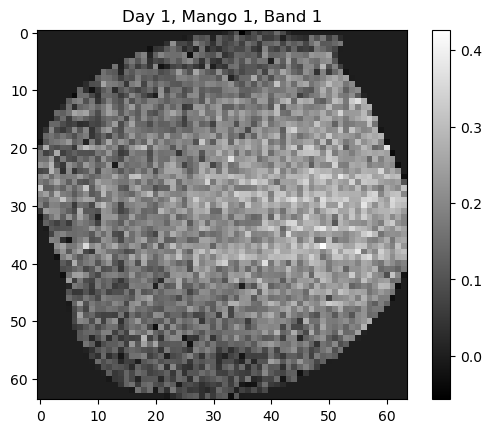

In [3]:
# Base directory of Mango/VIS
base_dir = "Mango/VIS"

# Load all mango data
mango_data = load_mango_data(base_dir)

# Example usage: Visualize first mango of the first day
example_day = 1
example_mango_id = 1
example_data = mango_data.get((example_day, example_mango_id))

if example_data is not None:
    plt.imshow(example_data[:, :, 0], cmap='gray')  # Display the first band
    plt.title(f"Day {example_day}, Mango {example_mango_id}, Band 1")
    plt.colorbar()
    plt.show()
else:
    print(f"No data found for day {example_day}, mango {example_mango_id}")

In [4]:
len(mango_data)

281

In [5]:
# 按芒果划分训练、验证和测试集
def split_data_by_mango(mango_data, train_ratio=0.7, val_ratio=0.15, random_seed=42):
    # 获取所有芒果 ID
    mango_ids = list({key[1] for key in mango_data.keys()})
    np.random.seed(random_seed)
    np.random.shuffle(mango_ids)

    # 划分训练、验证和测试集
    total = len(mango_ids)
    train_end = int(total * train_ratio)
    val_end = train_end + int(total * val_ratio)

    train_ids = mango_ids[:train_end]
    val_ids = mango_ids[train_end:val_end]
    test_ids = mango_ids[val_end:]

    # 将数据按芒果 ID 分组
    train_data = {key: value for key, value in mango_data.items() if key[1] in train_ids}
    val_data = {key: value for key, value in mango_data.items() if key[1] in val_ids}
    test_data = {key: value for key, value in mango_data.items() if key[1] in test_ids}

    return train_data, val_data, test_data

In [6]:
# 使用数据划分函数
train_data, val_data, test_data = split_data_by_mango(mango_data)
print(f"Train set mangos: {len(set(key[1] for key in train_data.keys()))}")
print(f"Validation set mangos: {len(set(key[1] for key in val_data.keys()))}")
print(f"Test set mangos: {len(set(key[1] for key in test_data.keys()))}")

Train set mangos: 28
Validation set mangos: 6
Test set mangos: 6


In [7]:
def prepare_dataset(mango_data):
    """
    Prepare dataset for a given mango data subset.
    
    Args:
        mango_data (dict): Dictionary with keys as (day, mango_id) and values as image data (numpy array).
        
    Returns:
        X (list): List of tuples, where each tuple contains two image matrices (image1, image2).
        y (list): List of corresponding time differences (in days).
    """
    X = []
    y = []
    
    # 按芒果 ID 分组
    mango_ids = set(key[1] for key in mango_data.keys())
    
    for mango_id in mango_ids:
        # 获取该芒果的所有天数数据
        mango_images = {day: mango_data[(day, mango_id)] for day in range(1, 13) if (day, mango_id) in mango_data}
        
        # 为每个芒果生成天数对
        day_pairs = list(combinations(mango_images.keys(), 2))
        
        for day1, day2 in day_pairs:
            image1 = mango_images[day1]
            image2 = mango_images[day2]
            X.append((image1, image2))
            y.append(abs(day1 - day2))  # 计算时间差标签
    
    return X, y

In [8]:
# 分别创建训练集、验证集和测试集的图片对
X_train, y_train = prepare_dataset(train_data)
X_val, y_val = prepare_dataset(val_data)
X_test, y_test = prepare_dataset(test_data)

In [9]:
class MangoDataset(Dataset):
    def __init__(self, X, y, transform=None):
        """
        Args:
            X (list): List of image pairs (image1, image2).
            y (list): List of corresponding labels (time difference).
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.X = X
        self.y = y
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        # Unpack image pair and label
        image1, image2 = self.X[idx]
        label = self.y[idx]

        # Convert (H, W, C) to (C, H, W)
        image1 = np.moveaxis(image1, -1, 0)
        image2 = np.moveaxis(image2, -1, 0)

        if self.transform:
            image1 = self.transform(image1)
            image2 = self.transform(image2)

        return (torch.tensor(image1, dtype=torch.float32),
                torch.tensor(image2, dtype=torch.float32),
                torch.tensor(label, dtype=torch.float32))

In [10]:
# 创建数据集和数据加载器
train_dataset = MangoDataset(X_train, y_train)
val_dataset = MangoDataset(X_val, y_val)
test_dataset = MangoDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [11]:
# Check a batch of data
for img1, img2, labels in train_loader:
    print(f"Image1 shape: {img1.shape}, Image2 shape: {img2.shape}, Labels shape: {labels.shape}")
    break

Image1 shape: torch.Size([16, 224, 64, 64]), Image2 shape: torch.Size([16, 224, 64, 64]), Labels shape: torch.Size([16])


In [12]:
print(f"train: {len(train_dataset)}")
print(f"validate: {len(val_dataset)}")
print(f"test: {len(test_dataset)}")

train: 763
validate: 122
test: 117


In [13]:
class SiameseNetwork(nn.Module):
    def __init__(self, input_size=(224, 64, 64)):  # Input channels set to 224
        super(SiameseNetwork, self).__init__()
        # Shared CNN
        self.cnn = nn.Sequential(
            nn.Conv2d(224, 64, kernel_size=3, stride=1, padding=1),  # Input channels adjusted to 224
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        # Dynamically compute the feature size after CNN
        with torch.no_grad():
            dummy_input = torch.zeros(1, *input_size)
            self.feature_size = self.cnn(dummy_input).view(1, -1).size(1)
        
        # Fully connected layers
        self.fc = nn.Sequential(
            nn.Linear(self.feature_size * 2, 512),  # *2 for concatenated features
            nn.ReLU(),
            nn.Linear(512, 1)  # Output single value (time difference)
        )

    def forward(self, img1, img2):
        # Extract features for both images
        feat1 = self.cnn(img1)
        feat2 = self.cnn(img2)
        
        # Flatten and concatenate features
        feat1 = torch.flatten(feat1, start_dim=1)
        feat2 = torch.flatten(feat2, start_dim=1)
        combined = torch.cat((feat1, feat2), dim=1)
        
        # Predict time difference
        output = self.fc(combined)
        return output


In [14]:
def train_and_evaluate_model(
    model, train_loader, val_loader, test_loader, device, epochs=100, lr=1e-3
):
    model = model.to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode="min", factor=0.5, patience=2, verbose=True
    )

    train_losses = []
    val_losses = []

    # Training and validation loop
    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0.0

        for img1, img2, labels in train_loader:
            img1, img2, labels = img1.to(device), img2.to(device), labels.to(device)

            # Forward pass
            outputs = model(img1, img2).squeeze(dim=1)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * img1.size(0)

        # Validation phase
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for img1, img2, labels in val_loader:
                img1, img2, labels = img1.to(device), img2.to(device), labels.to(device)
                outputs = model(img1, img2).squeeze(dim=1)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * img1.size(0)

        # Average losses
        train_loss /= len(train_loader.dataset)
        val_loss /= len(val_loader.dataset)

        # Record losses
        train_losses.append(train_loss)
        val_losses.append(val_loss)

        # Adjust learning rate based on validation loss
        scheduler.step(val_loss)

        # Print epoch statistics
        print(
            f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}"
        )
        print(f"Current Learning Rate: {optimizer.param_groups[0]['lr']:.6f}")

    # Plot loss curves
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, epochs + 1), train_losses, label="Train Loss")
    plt.plot(range(1, epochs + 1), val_losses, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss Over Epochs")
    plt.legend()
    plt.grid()
    plt.show()

    # Test phase
    print("Evaluating on test set...")
    test_loss = 0.0
    model.eval()
    with torch.no_grad():
        for img1, img2, labels in test_loader:
            img1, img2, labels = img1.to(device), img2.to(device), labels.to(device)
            outputs = model(img1, img2).squeeze(dim=1)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * img1.size(0)

    # Average test loss
    test_loss /= len(test_loader.dataset)
    print(f"Test Loss: {test_loss:.4f}")

    return model

/home/yiweizzz/.local/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1/100, Train Loss: 7.2580, Val Loss: 6.1699
Current Learning Rate: 0.000100
Epoch 2/100, Train Loss: 6.3324, Val Loss: 6.1571
Current Learning Rate: 0.000100
Epoch 3/100, Train Loss: 6.3422, Val Loss: 6.0664
Current Learning Rate: 0.000100
Epoch 4/100, Train Loss: 6.1692, Val Loss: 6.0282
Current Learning Rate: 0.000100
Epoch 5/100, Train Loss: 6.1393, Val Loss: 7.2954
Current Learning Rate: 0.000100
Epoch 6/100, Train Loss: 6.4901, Val Loss: 6.2603
Current Learning Rate: 0.000100
Epoch 7/100, Train Loss: 6.1507, Val Loss: 5.9360
Current Learning Rate: 0.000100
Epoch 8/100, Train Loss: 6.0377, Val Loss: 5.8180
Current Learning Rate: 0.000100
Epoch 9/100, Train Loss: 5.4412, Val Loss: 5.4052
Current Learning Rate: 0.000100
Epoch 10/100, Train Loss: 4.6190, Val Loss: 3.5983
Current Learning Rate: 0.000100
Epoch 11/100, Train Loss: 2.9523, Val Loss: 2.7946
Current Learning Rate: 0.000100
Epoch 12/100, Train Loss: 2.9732, Val Loss: 2.3016
Current Learning Rate: 0.000100
Epoch 13/100,

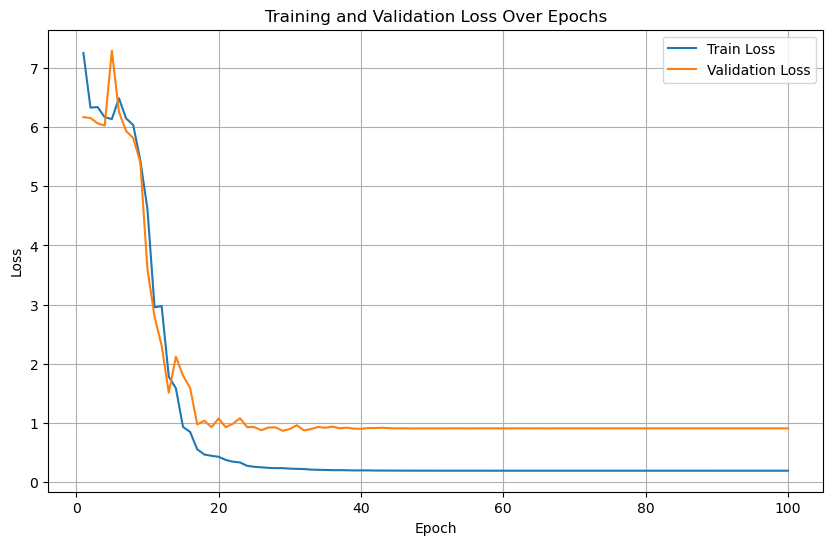

Evaluating on test set...
Test Loss: 0.8574


In [15]:
# Set device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 初始化模型
model = SiameseNetwork(input_size=(224, 64, 64))

# 运行训练并测试
trained_model = train_and_evaluate_model(
    model, train_loader, val_loader, test_loader, device, epochs=100, lr=1e-4
)

In [16]:
# 保存模型
def save_model(model, path="siamese_model.pth"):
    torch.save(model.state_dict(), path)
    print(f"Model saved to {path}")

# 保存训练好的模型
save_model(model, path="siamese_model.pth")

Model saved to siamese_model.pth


In [23]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [20]:
def extract_embeddings_from_fc(model, dataloader, device):
    """
    Extract embeddings from the penultimate fully connected layer of the Siamese model.

    Args:
        model: Trained Siamese model.
        dataloader: Dataloader providing image pairs and labels.
        device: Device to run the computations (e.g., 'cuda' or 'cpu').

    Returns:
        embeddings: A numpy array of extracted embeddings.
        labels: Corresponding time difference labels for each embedding.
    """
    model.eval()  # Set model to evaluation mode
    embeddings = []
    labels = []

    with torch.no_grad():
        for img1, img2, label in dataloader:
            img1, img2 = img1.to(device), img2.to(device)

            # Pass each image pair through the convolutional and fully connected layers
            feat1 = model.cnn(img1)
            feat2 = model.cnn(img2)

            # Flatten and concatenate the embeddings
            feat1 = torch.flatten(feat1, start_dim=1)
            feat2 = torch.flatten(feat2, start_dim=1)
            combined_embedding = torch.cat((feat1, feat2), dim=1)

            # Extract the output from the penultimate fully connected layer
            penultimate_embedding = model.fc[:-1](combined_embedding)

            embeddings.append(penultimate_embedding.cpu().numpy())
            labels.append(label.cpu().numpy())

    # Convert lists to numpy arrays
    embeddings = np.vstack(embeddings)
    labels = np.hstack(labels)

    return embeddings, labels


def visualize_embeddings(embeddings, labels):
    """
    Visualize embeddings in 2D using PCA.

    Args:
        embeddings: High-dimensional embeddings.
        labels: Corresponding labels for each embedding.
    """
    # Apply PCA to reduce dimensionality to 2D
    pca = PCA(n_components=2)
    reduced_embeddings = pca.fit_transform(embeddings)

    # Plot the embeddings
    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=labels, cmap='viridis', s=20)
    plt.colorbar(scatter, label='Day Difference')
    plt.title("Embedding Visualization (PCA) - Penultimate FC Layer")
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.grid(True)
    plt.show()

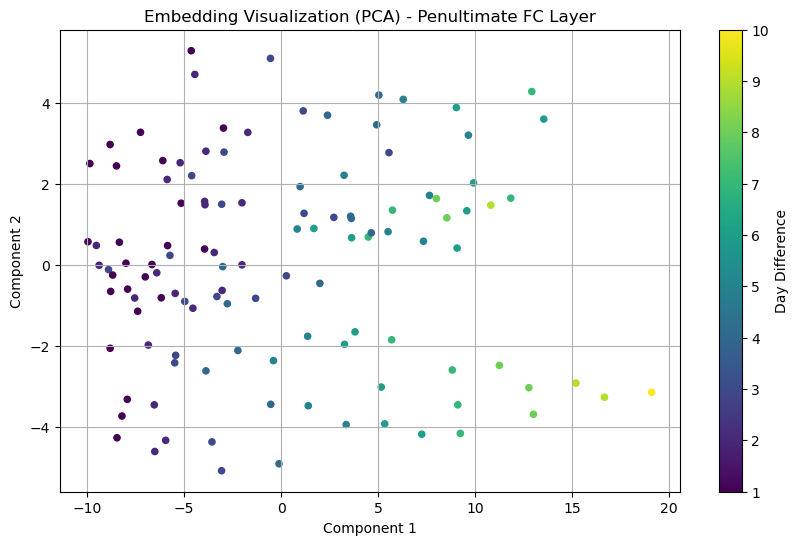

In [22]:
# Extract embeddings from the penultimate fully connected layer and visualize
embeddings, labels = extract_embeddings_from_fc(trained_model, test_loader, device)
visualize_embeddings(embeddings, labels)

In [24]:
def visualize_embeddings_tsne(embeddings, labels):
    """
    Visualize embeddings in 2D using t-SNE.

    Args:
        embeddings: High-dimensional embeddings.
        labels: Corresponding labels for each embedding.
    """
    # Apply t-SNE to reduce dimensionality to 2D
    tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
    reduced_embeddings = tsne.fit_transform(embeddings)

    # Plot the embeddings
    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=labels, cmap='viridis', s=20)
    plt.colorbar(scatter, label='Day Difference')
    plt.title("Embedding Visualization (t-SNE) - Penultimate FC Layer")
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.grid(True)
    plt.show()

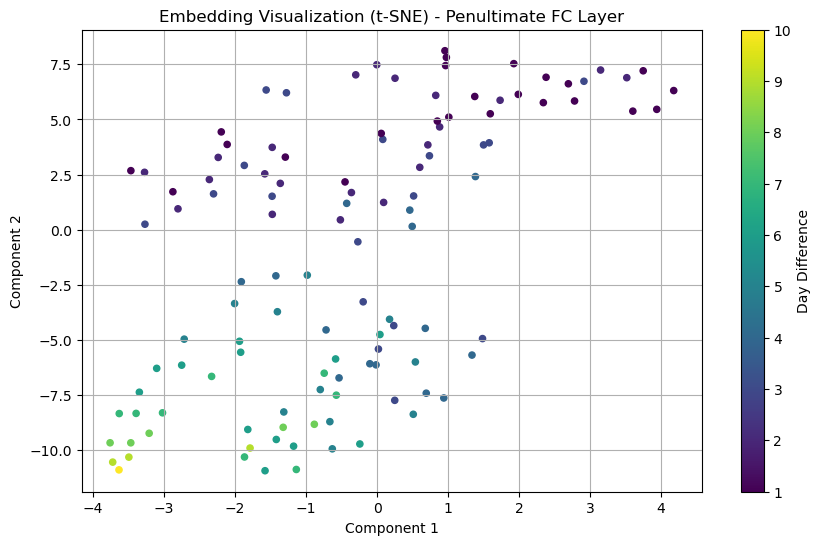

In [25]:
# Extract embeddings from the penultimate fully connected layer and visualize using t-SNE
embeddings, labels = extract_embeddings_from_fc(trained_model, test_loader, device)
visualize_embeddings_tsne(embeddings, labels)